In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No Standerscaler and no opt

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2668 - loss: 1.2698 - val_accuracy: 0.4778 - val_loss: 1.0153
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5040 - loss: 1.0116 - val_accuracy: 0.5778 - val_loss: 0.9433
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4823 - loss: 1.0421 - val_accuracy: 0.6222 - val_loss: 0.8884
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5346 - loss: 0.9022 - val_accuracy: 0.6222 - val_loss: 0.8226
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5973 - loss: 0.8539 - val_accuracy: 0.6333 - val_loss: 0.8063
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6226 - loss: 0.8032 - val_accuracy: 0.5556 - val_loss: 0.8933
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6012 - loss: 0.8813 - val_accuracy: 0.6667 - val_loss: 0.8057
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6246 - loss: 0.8456 - val_accuracy: 0.8000 - val_loss: 0.7433
Epoch 9/30
7

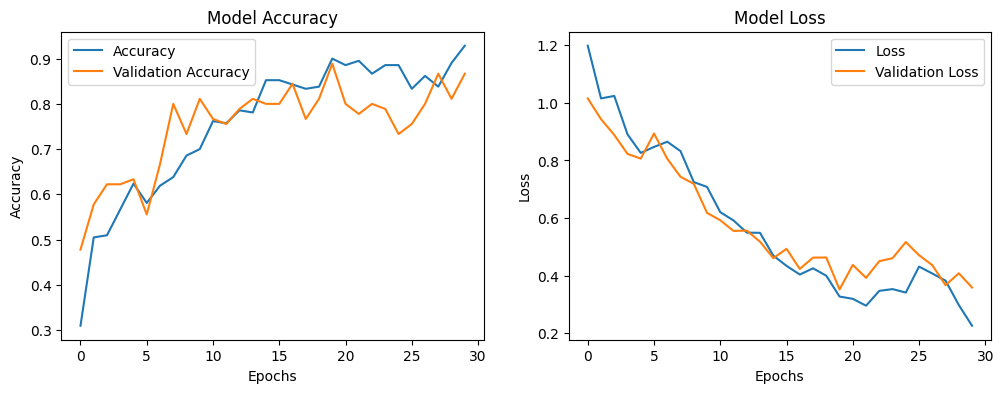

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with categorical crossentropy loss (multi-class classification)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


With standerscaler

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5017 - loss: 1.0374 - val_accuracy: 0.5556 - val_loss: 0.8831
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5799 - loss: 0.8428 - val_accuracy: 0.6000 - val_loss: 0.6455
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6089 - loss: 0.7289 - val_accuracy: 0.5111 - val_loss: 0.8156
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6291 - loss: 0.7243 - val_accuracy: 0.5111 - val_loss: 0.8869
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6702 - loss: 0.5583 - val_accuracy: 0.6889 - val_loss: 0.4981
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6475 - loss: 0.5457 - val_accuracy: 0.6111 - val_loss: 0.5445
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6625 - loss: 0.5608 - val_accuracy: 0.6222 - val_loss: 0.4989
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7510 - loss: 0.4556 - val_accuracy: 0.6000 - val_loss: 0.5279
Epoch 9/30
7/7 ━━━━━━━

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step

Final Evaluation Metrics:
Test Accuracy:  0.6555555555555556
Test Recall (Weighted):  0.6555555555555556
Test Precision (Weighted):  0.6739714215323971
Test F1 Score (Weighted):  0.6487244681752691
Confusion Matrix: 
 [[13 22  0]
 [ 9 19  0]
 [ 0  0 27]]
Training time:  309.1385431289673


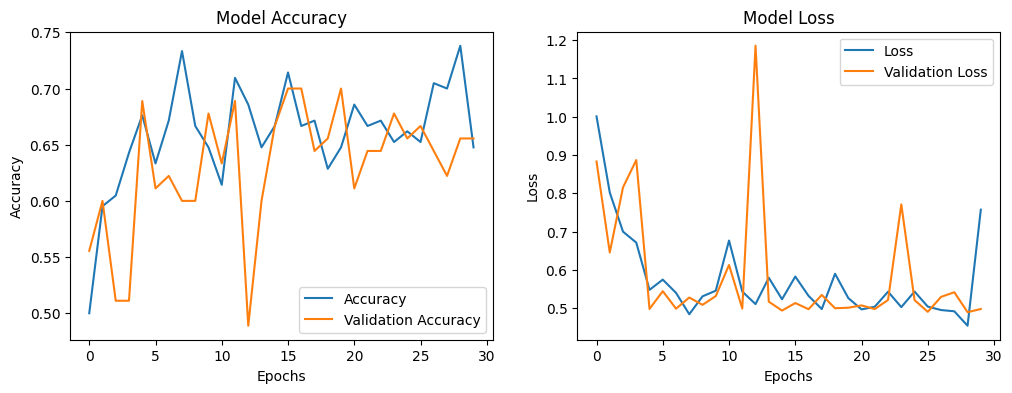

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Apply StandardScaler to the data
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform both training and testing data
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with categorical crossentropy loss (multi-class classification)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


With Optmiser

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3120 - loss: 1.1815 - val_accuracy: 0.4000 - val_loss: 1.0155
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4336 - loss: 1.0550 - val_accuracy: 0.6000 - val_loss: 0.9636
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4988 - loss: 0.9952 - val_accuracy: 0.7222 - val_loss: 0.9573
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6286 - loss: 0.8631 - val_accuracy: 0.7222 - val_loss: 0.8808
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6899 - loss: 0.7962 - val_accuracy: 0.7000 - val_loss: 0.8078
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6607 - loss: 0.8013 - val_accuracy: 0.7667 - val_loss: 0.7375
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7320 - loss: 0.6906 - val_accuracy: 0.7667 - val_loss: 0.7191
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7139 - loss: 0.7345 - val_accuracy: 0.7556 - val_loss: 0.7018
Epoch 9/30

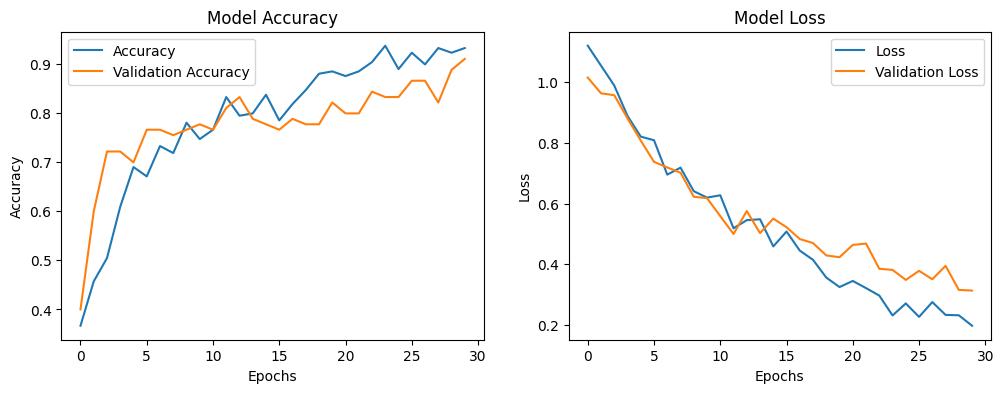

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


with both standerscaler and op

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3993 - loss: 1.0678 - val_accuracy: 0.3111 - val_loss: 0.9690
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3786 - loss: 0.9669 - val_accuracy: 0.4111 - val_loss: 0.8744
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5758 - loss: 0.8405 - val_accuracy: 0.6000 - val_loss: 0.7603
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6337 - loss: 0.7856 - val_accuracy: 0.6111 - val_loss: 0.6839
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6381 - loss: 0.7682 - val_accuracy: 0.6111 - val_loss: 0.6459
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6948 - loss: 0.6123 - val_accuracy: 0.6000 - val_loss: 0.6236
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6287 - loss: 0.6801 - val_accuracy: 0.6778 - val_loss: 0.5360
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6323 - loss: 0.7517 - val_accuracy: 0.5111 - val_loss: 1.1534
Epoch 9/30
7/7 ━━━━━━

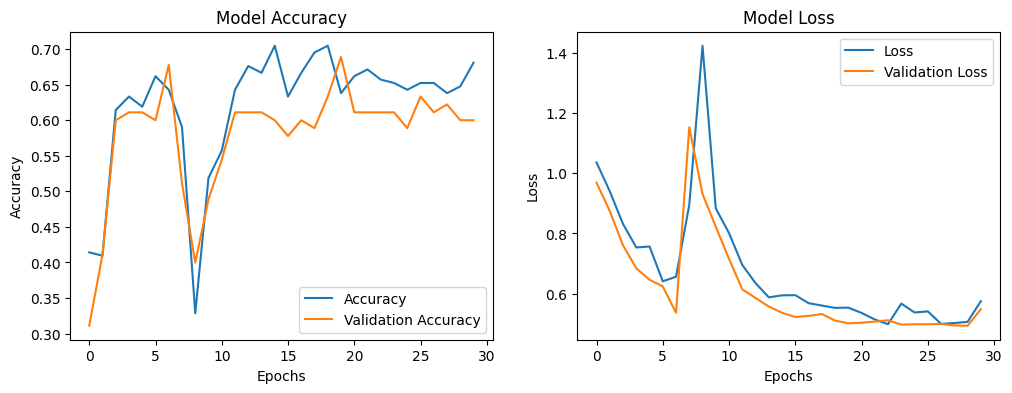

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)  # Seizure (S)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Apply StandardScaler to the data
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform both training and testing data
    X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Multi-class classification (3 classes: Healthy, Epileptic, Seizure)
    ])

    # Compile the model with categorical crossentropy loss (multi-class classification)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0, 1, or 2)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='weighted')  # Weighted average for multi-class
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Weighted): ", recall)
    print("Test Precision (Weighted): ", precision)
    print("Test F1 Score (Weighted): ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")
